<a href="https://colab.research.google.com/github/Krumpu/Homework_ICA/blob/main/HW_1_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importação de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parte 1 - Leitura e ajuste dos dados csv

### PASSOS:
1 - Leitura dos dados; \
2 - Segundo a descrição do dataset foram removidos diversos registros que continham valores nulos, consumo de energia muito baixo (próximo a zero), consumos extremamente elevados, valores de atributos irrelevantes e dados atípicos (outliers) — pontos que diferem significativamente das demais observações. Por isso não precisaremos fazer esse tratamentos

In [3]:
url = "https://raw.githubusercontent.com/Krumpu/Homework_ICA/main/Data-Melbourne_F.csv"
df = pd.read_csv(url)
df


,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,TM,Tm,SLP,H,PP,VV,V,VM,VG,year,month,day
0,2.941,2.589,175856,27.0,365.0,730.0,60.378,19.3,25.1,12.6,0.0,56,1.52,10.0,26.9,53.5,79.5,2014,1,1
1,2.936,2.961,181624,25.0,370.0,740.0,60.026,17.1,23.6,12.3,0.0,63,0.00,10.0,14.4,27.8,0.0,2014,1,2
2,2.928,3.225,202016,42.0,418.0,836.0,64.522,16.8,27.2,8.8,0.0,47,0.25,10.0,31.9,61.1,77.8,2014,1,5
3,2.928,3.354,207547,36.0,430.0,850.0,63.000,14.6,19.9,11.1,0.0,49,0.00,10.0,27.0,38.9,53.5,2014,1,6
4,2.917,3.794,202824,46.0,508.0,1016.0,65.590,13.4,19.1,8.0,0.0,65,0.00,10.0,20.6,35.2,53.5,2014,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,5.068,4.716,305938,28.0,310.0,660.0,58.807,6.8,10.0,4.0,0.0,56,0.00,10.0,14.4,22.2,0.0,2019,6,20
1378,5.882,5.510,293446,40.0,250.0,700.0,60.671,7.6,16.0,3.0,0.0,71,0.00,0.0,13.5,25.9,0.0,2019,6,24
1379,4.638,4.811,307968,47.0,260.0,860.0,64.000,9.7,16.0,3.0,0.0,65,0.00,10.0,18.1,25.9,0.0,2019,6,25
1380,5.373,4.929,316675,46.0,300.0,900.0,62.479,10.9,17.0,5.0,0.0,65,0.00,10.0,21.9,35.2,51.9,2019,6,26


Data (excluding day/month/year)\
avg-outflow: Average Outflow (Qout, m^3/s)\
avg-inflow: Average Inflow (Qin, m^3/s)\
total_grid: Daily Total Grid Power Consumption (Ec, MWh)\
Am: Ammonia (NH4-N, mg/L)\
BOD: Biological Oxygen Demand (mg/L)\
COD: Chemical Oxygen Demand (mg/L)\
TN: Total Nitrogen (mg/L)\
T: Average Temperature (Tavg, °C)\
TM: Maximum Temperature (Tmax, °C)\
Tm: Minimum Temperature (Tmin, °C)\
SLP: Atmospheric Pressure (AP, hPa)\
H: Average Relative Humidity (H, %)\
PP: Total Rainfall and/or Snowmelt (Pr, mm)\
VV: Average Visibility (VIS, Km)\
V: Average Wind Speed (WSavg, Km/h)\
VM: Maximum Wind Speed (WSmax, Km/h)\
VG: Unknown/Unused?

3 - Determinação do número de amostras, preditores, número e distribuição de classes. Não consideraremos as colunas VG (por falta de informações sobre ela e seu significado) nem a data como preditores.

In [8]:
predictors = df.drop(columns=['VG', 'year', 'month', 'day'])
num_predictors = predictors.shape[1]
print("Number of predictors: ", num_predictors)

Number of predictors:  16


*N* : 1381 número de amostras \
*D* : 16 preditores\
*L* : Tô com duvida, pq na minha concepção a gente pode usar duas categorias "Desperdicio" e "Economia" nesse caso seriam 2, olhem essa parte


<Axes: xlabel='avg_inflow', ylabel='Count'>

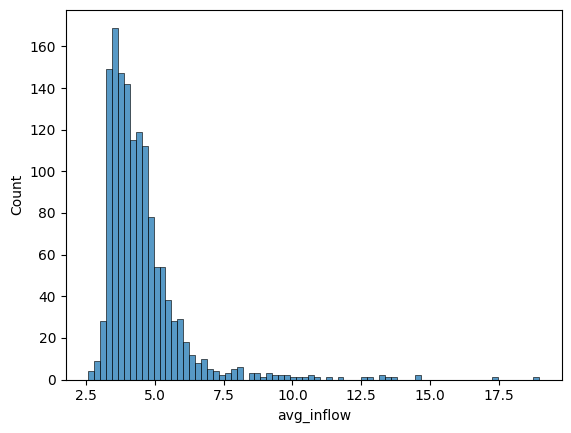

In [ ]:
sns.histplot(df['avg_inflow'])